In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import glob

import sklearn
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, recall_score, precision_score
from sklearn.metrics import f1_score

# REFER THIS FOR GRAPHS FOR ITERATION 1

In [44]:
ENCRYPTED_DIRECTORY = "data/govdocs_encrypted"
PLAINTEXT_DIRECTORY = "data/govdocs_plaintext"

In [45]:
def load_data(directory):
    dataframes = list()
    for f in glob.glob(f"{directory}/**.csv.gz"):
        df = pd.read_csv(f)
        dataframes.append(df)
    return pd.concat(dataframes)

df_plaintext = load_data(PLAINTEXT_DIRECTORY)
df_plaintext["is_encrypted"] = 0
df_encrypted = load_data(ENCRYPTED_DIRECTORY)
df_encrypted["is_encrypted"] = 1

master_df = pd.concat([df_plaintext, df_encrypted])

# Filter out only webp
# master_df = master_df[master_df['extended.extension'] != '.webp']
print("only webp: ", master_df.shape)

# Filter out files which are larger than 4k
#master_df = master_df[master_df['baseline.filesize'] > 4096]
print("greater than 4096: ", master_df.shape)

# Shuffle
master_df = master_df.sample(frac=1).reset_index(drop=True)

# fill Nan with 0
master_df['baseline.chisquare_end'] = master_df['baseline.chisquare_end'].fillna(0.0)
master_df.dropna(inplace=True)
master_df = master_df.copy()

baseline_columns = [c for c in master_df.columns if "baseline" in c.lower() and "filesize" not in c.lower()]
advanced_columns = [c for c in master_df.columns if "kurtosis" in c.lower() or "skew" in c.lower()]

/var/folders/z1/hfz3q2b52bx3hb8nh0z1q89c0000gp/T/ipykernel_28513/3076509417.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_plaintext["is_encrypted"] = 0
/var/folders/z1/hfz3q2b52bx3hb8nh0z1q89c0000gp/T/ipykernel_28513/3076509417.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_encrypted["is_encrypted"] = 1


only webp:  (160507, 528)
greater than 4096:  (160507, 528)


In [46]:
#columns_to_consider = [c for c in master_df.columns]
#columns_to_consider = [c for c in master_df.columns if c.startswith("baseline")]
#columns_to_consider.append('is_encrypted')
columns_to_consider = [c for c in master_df.columns if c != 'extended.extension']


interesting_df = master_df[columns_to_consider]

X = interesting_df[[c for c in interesting_df.columns if c.startswith('baseline')]]
X = interesting_df[[c for c in interesting_df.columns if c != 'is_encrypted']]
X = X[[c for c in X.columns if c != 'is_encrypted']]
X = X[baseline_columns + advanced_columns]

# get rid of tail and head metrics
X = X[[c for c in X.columns if "begin" not in c and "head" not in c]]
X = X[[c for c in X.columns if "tail" not in c and "end" not in c]]

X = X[[c for c in X.columns if "kurtosis" not in c and "skew" not in c]]

y = interesting_df['is_encrypted']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

# ---------------------------------------------------------------

rfc = RandomForestClassifier(n_jobs=-1)
estimators = [('std,', MinMaxScaler()), ('LogisticRegressor', LogisticRegression(n_jobs=10, max_iter=1000))]
pipeline = Pipeline(estimators)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print(f"Precision : {precision}")
print(f"Recall    : {recall}")
print(f"Accuracy  : {accuracy}")
print(f"F1-score  : {f1}")

df_json = {
    "Extremities_Measured_Separately": [],
    "Algorithm": [],
    "Accuracy": [],
    "Precision": [],
    "Recall": [],
    "F1": []
}

df_json["Extremities_Measured_Separately"].append("NO")
df_json["Algorithm"].append("Logistic Regression")
df_json["Accuracy"].append(accuracy)
df_json["Precision"].append(precision)
df_json["Recall"].append(recall)
df_json["F1"].append(f1)

Precision : 0.6125529173568931
Recall    : 0.9068119891008174
Accuracy  : 0.6729046918861115
F1-score  : 0.7311875205976052


## Now try the same thing with extremity measurements separately

In [47]:
columns_to_consider = [c for c in master_df.columns if c != 'extended.extension']

interesting_df = master_df[columns_to_consider]

X = interesting_df[[c for c in interesting_df.columns if c.startswith('baseline')]]
X = interesting_df[[c for c in interesting_df.columns if c != 'is_encrypted']]
X = X[baseline_columns + advanced_columns]

X = X[[c for c in X.columns if c != 'is_encrypted']]

# get rid of tail and head metrics
# X = X[[c for c in X.columns if "begin" not in c and "head" not in c]]
# X = X[[c for c in X.columns if "tail" not in c and "end" not in c]]

X = X[[c for c in X.columns if "kurtosis" not in c and "skew" not in c]]

y = interesting_df['is_encrypted']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

rfc = RandomForestClassifier(n_jobs=-1)
estimators = [('std,', MinMaxScaler()), ('LogisticRegressor', LogisticRegression(n_jobs=10,  max_iter=1000))]
pipeline = Pipeline(estimators)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print(f"Precision : {precision}")
print(f"Recall    : {recall}")
print(f"Accuracy  : {accuracy}")
print(f"F1-score  : {f1}")


df_json["Extremities_Measured_Separately"].append("YES")
df_json["Algorithm"].append("Logistic Regression")
df_json["Accuracy"].append(accuracy)
df_json["Precision"].append(precision)
df_json["Recall"].append(recall)
df_json["F1"].append(f1)

Precision : 0.7220383069283518
Recall    : 0.832016348773842
Accuracy  : 0.7604598315733191
F1-score  : 0.7731358399797443


In [48]:
#columns_to_consider = [c for c in master_df.columns]
#columns_to_consider = [c for c in master_df.columns if c.startswith("baseline")]
#columns_to_consider.append('is_encrypted')
columns_to_consider = [c for c in master_df.columns if c != 'extended.extension']


interesting_df = master_df[columns_to_consider]

X = interesting_df[[c for c in interesting_df.columns if c.startswith('baseline')]]
X = interesting_df[[c for c in interesting_df.columns if c != 'is_encrypted']]
X = X[baseline_columns + advanced_columns]

X = X[[c for c in X.columns if c != 'is_encrypted']]

# get rid of tail and head metrics
X = X[[c for c in X.columns if "begin" not in c and "head" not in c]]
X = X[[c for c in X.columns if "tail" not in c and "end" not in c]]

X = X[[c for c in X.columns if "kurtosis" not in c and "skew" not in c]]

y = interesting_df['is_encrypted']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

# -----------------------------------


rfc = RandomForestClassifier(n_jobs=-1)
estimators = [('std,', MinMaxScaler()), ('RFC', rfc)]
pipeline = Pipeline(estimators)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print(f"Precision : {precision}")
print(f"Recall    : {recall}")
print(f"Accuracy  : {accuracy}")
print(f"F1-score  : {f1}")

df_json["Extremities_Measured_Separately"].append("NO")
df_json["Algorithm"].append("Random Forest")
df_json["Accuracy"].append(accuracy)
df_json["Precision"].append(precision)
df_json["Recall"].append(recall)
df_json["F1"].append(f1)

Precision : 0.6300172371337109
Recall    : 0.6971389645776567
Accuracy  : 0.6505814730650983
F1-score  : 0.6618807398784116


<AxesSubplot:xlabel='Importance', ylabel='Feature'>

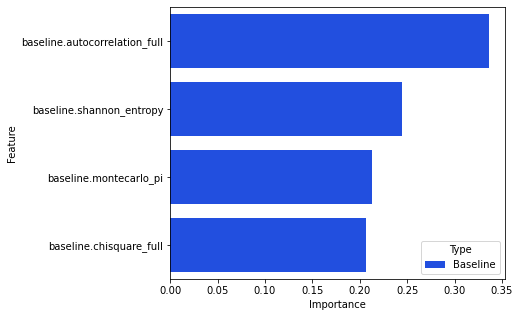

In [49]:
import seaborn as sns
plt.rcParams["figure.figsize"] = (6,5)

columns = np.array([c for c in X_train.columns])
sort_array = np.argsort(rfc.feature_importances_)[::-1]
df = pd.DataFrame({"Feature": X_train.columns[sort_array], "Importance": rfc.feature_importances_[sort_array]})

def get_type(x):
    return "Advanced" if "advanced" in x.lower() else "Baseline"

df["Type"] = df["Feature"].map(get_type)
      
#plt.barh(X_train.columns[sort_array], rfc.feature_importances_[sort_array])
sns.barplot(y="Feature", x="Importance", hue="Type", data=df, palette="bright", dodge=False)

In [50]:
#columns_to_consider = [c for c in master_df.columns]
#columns_to_consider = [c for c in master_df.columns if c.startswith("baseline")]
#columns_to_consider.append('is_encrypted')
columns_to_consider = [c for c in master_df.columns if c != 'extended.extension']


interesting_df = master_df[columns_to_consider]

X = interesting_df[[c for c in interesting_df.columns if c.startswith('baseline')]]
X = interesting_df[[c for c in interesting_df.columns if c != 'is_encrypted']]
X = X[baseline_columns + advanced_columns]


X = X[[c for c in X.columns if c != 'is_encrypted']]

# get rid of tail and head metrics
#X = X[[c for c in X.columns if "begin" not in c and "head" not in c]]
#X = X[[c for c in X.columns if "tail" not in c and "end" not in c]]

X = X[[c for c in X.columns if "kurtosis" not in c and "skew" not in c]]

y = interesting_df['is_encrypted']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

# -----------------------------------


rfc = RandomForestClassifier(n_jobs=-1)
estimators = [('std,', MinMaxScaler()), ('RFC', rfc)]
pipeline = Pipeline(estimators)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print(f"Precision : {precision}")
print(f"Recall    : {recall}")
print(f"Accuracy  : {accuracy}")
print(f"F1-score  : {f1}")

df_json["Extremities_Measured_Separately"].append("YES")
df_json["Algorithm"].append("Random Forest")
df_json["Accuracy"].append(accuracy)
df_json["Precision"].append(precision)
df_json["Recall"].append(recall)
df_json["F1"].append(f1)

Precision : 0.7439713380184649
Recall    : 0.735558583106267
Accuracy  : 0.746090094907098
F1-score  : 0.7397410426800027


<AxesSubplot:xlabel='Importance', ylabel='Feature'>

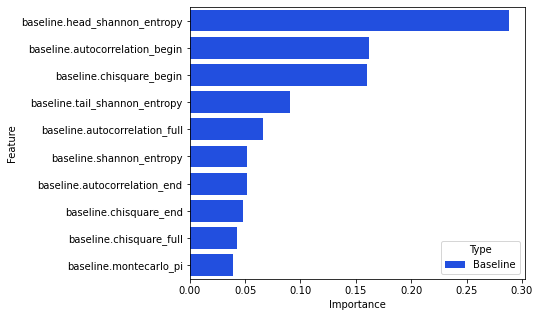

In [51]:
import seaborn as sns
plt.rcParams["figure.figsize"] = (6,5)

columns = np.array([c for c in X_train.columns])
sort_array = np.argsort(rfc.feature_importances_)[::-1]
df = pd.DataFrame({"Feature": X_train.columns[sort_array], "Importance": rfc.feature_importances_[sort_array]})

def get_type(x):
    return "Advanced" if "advanced" in x.lower() else "Baseline"

df["Type"] = df["Feature"].map(get_type)
      
#plt.barh(X_train.columns[sort_array], rfc.feature_importances_[sort_array])
sns.barplot(y="Feature", x="Importance", hue="Type", data=df, palette="bright", dodge=False)

In [52]:
df = pd.DataFrame(df_json)


In [53]:
df

,Extremities_Measured_Separately,Algorithm,Accuracy,Precision,Recall,F1
0,NO,Logistic Regression,0.672905,0.612553,0.906812,0.731188
1,YES,Logistic Regression,0.760460,0.722038,0.832016,0.773136
2,NO,Random Forest,0.650581,0.630017,0.697139,0.661881
3,YES,Random Forest,0.746090,0.743971,0.735559,0.739741


In [54]:
print(df.to_latex())

\begin{tabular}{lllrrrr}
\toprule
{} & Extremities\_Measured\_Separately &            Algorithm &  Accuracy &  Precision &    Recall &        F1 \\
\midrule
0 &                              NO &  Logistic Regression &  0.672905 &   0.612553 &  0.906812 &  0.731188 \\
1 &                             YES &  Logistic Regression &  0.760460 &   0.722038 &  0.832016 &  0.773136 \\
2 &                              NO &        Random Forest &  0.650581 &   0.630017 &  0.697139 &  0.661881 \\
3 &                             YES &        Random Forest &  0.746090 &   0.743971 &  0.735559 &  0.739741 \\
\bottomrule
\end{tabular}



### Now add kurtosis and skew to the same thing and measure again

In [55]:
#columns_to_consider = [c for c in master_df.columns]
#columns_to_consider = [c for c in master_df.columns if c.startswith("baseline")]
#columns_to_consider.append('is_encrypted')
columns_to_consider = [c for c in master_df.columns if c != 'extended.extension']


interesting_df = master_df[columns_to_consider]

X = interesting_df[[c for c in interesting_df.columns if c.startswith('baseline')]]
X = interesting_df[[c for c in interesting_df.columns if c != 'is_encrypted']]
X = X[baseline_columns + advanced_columns]


X = X[[c for c in X.columns if c != 'is_encrypted']]

# get rid of tail and head metrics
X = X[[c for c in X.columns if "begin" not in c and "head" not in c]]
X = X[[c for c in X.columns if "tail" not in c and "end" not in c]]

# X = X[[c for c in X.columns if "kurtosis" not in c and "skew" not in c]]

y = interesting_df['is_encrypted']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

# ---------------------------------------------------------------

rfc = RandomForestClassifier(n_jobs=-1)
estimators = [('std,', MinMaxScaler()), ('LogisticRegressor', LogisticRegression(n_jobs=10, max_iter=1000))]
pipeline = Pipeline(estimators)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print(f"Precision : {precision}")
print(f"Recall    : {recall}")
print(f"Accuracy  : {accuracy}")
print(f"F1-score  : {f1}")

df_json2 = {
    "Extremities_Measured_Separately": [],
    "Algorithm": [],
    "Accuracy": [],
    "Precision": [],
    "Recall": [],
    "F1": []
}

df_json2["Extremities_Measured_Separately"].append("NO")
df_json2["Algorithm"].append("Logistic Regression")
df_json2["Accuracy"].append(accuracy)
df_json2["Precision"].append(precision)
df_json2["Recall"].append(recall)
df_json2["F1"].append(f1)

Precision : 0.6123895434462445
Recall    : 0.9064032697547684
Accuracy  : 0.6726373479481352
F1-score  : 0.7309382553284992


In [56]:
#columns_to_consider = [c for c in master_df.columns]
#columns_to_consider = [c for c in master_df.columns if c.startswith("baseline")]
#columns_to_consider.append('is_encrypted')
columns_to_consider = [c for c in master_df.columns if c != 'extended.extension']


interesting_df = master_df[columns_to_consider]

X = interesting_df[[c for c in interesting_df.columns if c.startswith('baseline')]]
X = interesting_df[[c for c in interesting_df.columns if c != 'is_encrypted']]
X = X[baseline_columns + advanced_columns]


X = X[[c for c in X.columns if c != 'is_encrypted']]

# get rid of tail and head metrics
# X = X[[c for c in X.columns if "begin" not in c and "head" not in c]]
# X = X[[c for c in X.columns if "tail" not in c and "end" not in c]]

# X = X[[c for c in X.columns if "kurtosis" not in c and "skew" not in c]]

y = interesting_df['is_encrypted']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

# ---------------------------------------------------------------

rfc = RandomForestClassifier(n_jobs=-1)
estimators = [('std,', MinMaxScaler()), ('LogisticRegressor', LogisticRegression(n_jobs=10, max_iter=1000))]
#estimators = [('std,', MinMaxScaler()), ('RFC', rfc)]
pipeline = Pipeline(estimators)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print(f"Precision : {precision}")
print(f"Recall    : {recall}")
print(f"Accuracy  : {accuracy}")
print(f"F1-score  : {f1}")


df_json2["Extremities_Measured_Separately"].append("YES")
df_json2["Algorithm"].append("Logistic Regression")
df_json2["Accuracy"].append(accuracy)
df_json2["Precision"].append(precision)
df_json2["Recall"].append(recall)
df_json2["F1"].append(f1)

Precision : 0.7317161477190441
Recall    : 0.8260217983651226
Accuracy  : 0.7660740542708194
F1-score  : 0.7760143350825547


In [57]:
#columns_to_consider = [c for c in master_df.columns]
#columns_to_consider = [c for c in master_df.columns if c.startswith("baseline")]
#columns_to_consider.append('is_encrypted')
columns_to_consider = [c for c in master_df.columns if c != 'extended.extension']


interesting_df = master_df[columns_to_consider]

X = interesting_df[[c for c in interesting_df.columns if c.startswith('baseline')]]
X = interesting_df[[c for c in interesting_df.columns if c != 'is_encrypted']]
X = X[baseline_columns + advanced_columns]
X = X[[c for c in X.columns if c != 'is_encrypted']]

# get rid of tail and head metrics
X = X[[c for c in X.columns if "begin" not in c and "head" not in c]]
X = X[[c for c in X.columns if "tail" not in c and "end" not in c]]

# X = X[[c for c in X.columns if "kurtosis" not in c and "skew" not in c]]

y = interesting_df['is_encrypted']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

# ---------------------------------------------------------------

rfc = RandomForestClassifier(n_jobs=-1)
#estimators = [('std,', MinMaxScaler()), ('LogisticRegressor', LogisticRegression(n_jobs=10, max_iter=1000))]
estimators = [('std,', MinMaxScaler()), ('RFC', rfc)]
pipeline = Pipeline(estimators)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print(f"Precision : {precision}")
print(f"Recall    : {recall}")
print(f"Accuracy  : {accuracy}")
print(f"F1-score  : {f1}")

df_json2["Extremities_Measured_Separately"].append("NO")
df_json2["Algorithm"].append("Random Forest")
df_json2["Accuracy"].append(accuracy)
df_json2["Precision"].append(precision)
df_json2["Recall"].append(recall)
df_json2["F1"].append(f1)

Precision : 0.6252570460868513
Recall    : 0.7042234332425068
Accuracy  : 0.6478411977008421
F1-score  : 0.662395079131159


<AxesSubplot:xlabel='Importance', ylabel='Feature'>

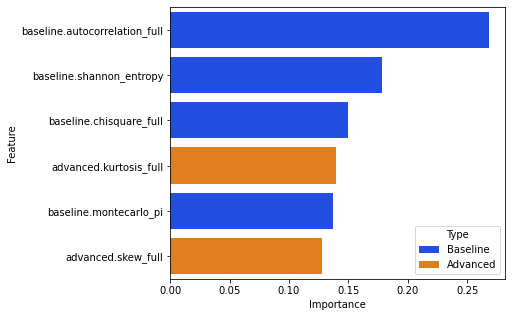

In [58]:
import seaborn as sns
plt.rcParams["figure.figsize"] = (6,5)

columns = np.array([c for c in X_train.columns])
sort_array = np.argsort(rfc.feature_importances_)[::-1]
df = pd.DataFrame({"Feature": X_train.columns[sort_array], "Importance": rfc.feature_importances_[sort_array]})

def get_type(x):
    return "Advanced" if "advanced" in x.lower() else "Baseline"

df["Type"] = df["Feature"].map(get_type)
      
#plt.barh(X_train.columns[sort_array], rfc.feature_importances_[sort_array])
sns.barplot(y="Feature", x="Importance", hue="Type", data=df, palette="bright", dodge=False)

In [59]:
#columns_to_consider = [c for c in master_df.columns]
#columns_to_consider = [c for c in master_df.columns if c.startswith("baseline")]
#columns_to_consider.append('is_encrypted')
columns_to_consider = [c for c in master_df.columns if c != 'extended.extension']


interesting_df = master_df[columns_to_consider]

X = interesting_df[[c for c in interesting_df.columns if c.startswith('baseline')]]
X = interesting_df[[c for c in interesting_df.columns if c != 'is_encrypted']]
X = X[baseline_columns + advanced_columns]

X = X[[c for c in X.columns if c != 'is_encrypted']]

# get rid of tail and head metrics
# X = X[[c for c in X.columns if "begin" not in c and "head" not in c]]
# X = X[[c for c in X.columns if "tail" not in c and "end" not in c]]

# X = X[[c for c in X.columns if "kurtosis" not in c and "skew" not in c]]

y = interesting_df['is_encrypted']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

# ---------------------------------------------------------------

rfc = RandomForestClassifier(n_jobs=-1)
#estimators = [('std,', MinMaxScaler()), ('LogisticRegressor', LogisticRegression(n_jobs=10, max_iter=1000))]
estimators = [('std,', MinMaxScaler()), ('RFC', rfc)]
pipeline = Pipeline(estimators)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print(f"Precision : {precision}")
print(f"Recall    : {recall}")
print(f"Accuracy  : {accuracy}")
print(f"F1-score  : {f1}")

df_json2["Extremities_Measured_Separately"].append("YES")
df_json2["Algorithm"].append("Random Forest")
df_json2["Accuracy"].append(accuracy)
df_json2["Precision"].append(precision)
df_json2["Recall"].append(recall)
df_json2["F1"].append(f1)

Precision : 0.745351879906349
Recall    : 0.7373297002724796
Accuracy  : 0.7475604865659671
F1-score  : 0.7413190877337169


<AxesSubplot:xlabel='Importance', ylabel='Feature'>

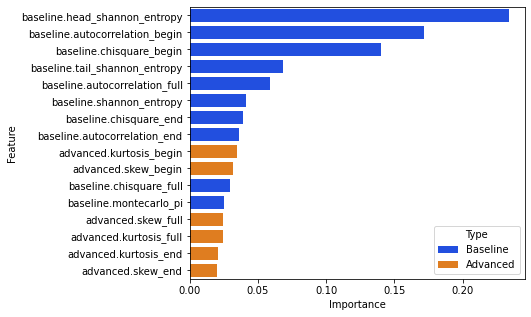

In [60]:
import seaborn as sns
plt.rcParams["figure.figsize"] = (6,5)

columns = np.array([c for c in X_train.columns])
sort_array = np.argsort(rfc.feature_importances_)[::-1]
df = pd.DataFrame({"Feature": X_train.columns[sort_array], "Importance": rfc.feature_importances_[sort_array]})

def get_type(x):
    return "Advanced" if "advanced" in x.lower() else "Baseline"

df["Type"] = df["Feature"].map(get_type)
      
#plt.barh(X_train.columns[sort_array], rfc.feature_importances_[sort_array])
sns.barplot(y="Feature", x="Importance", hue="Type", data=df, palette="bright", dodge=False)

In [61]:
df2 = pd.DataFrame(df_json2)
df2

,Extremities_Measured_Separately,Algorithm,Accuracy,Precision,Recall,F1
0,NO,Logistic Regression,0.672637,0.612390,0.906403,0.730938
1,YES,Logistic Regression,0.766074,0.731716,0.826022,0.776014
2,NO,Random Forest,0.647841,0.625257,0.704223,0.662395
3,YES,Random Forest,0.747560,0.745352,0.737330,0.741319


In [62]:
print(df2.to_latex())

\begin{tabular}{lllrrrr}
\toprule
{} & Extremities\_Measured\_Separately &            Algorithm &  Accuracy &  Precision &    Recall &        F1 \\
\midrule
0 &                              NO &  Logistic Regression &  0.672637 &   0.612390 &  0.906403 &  0.730938 \\
1 &                             YES &  Logistic Regression &  0.766074 &   0.731716 &  0.826022 &  0.776014 \\
2 &                              NO &        Random Forest &  0.647841 &   0.625257 &  0.704223 &  0.662395 \\
3 &                             YES &        Random Forest &  0.747560 &   0.745352 &  0.737330 &  0.741319 \\
\bottomrule
\end{tabular}



In [63]:
df

,Feature,Importance,Type
0,baseline.head_shannon_entropy,0.233664,Baseline
1,baseline.autocorrelation_begin,0.171729,Baseline
2,baseline.chisquare_begin,0.140350,Baseline
3,baseline.tail_shannon_entropy,0.068272,Baseline
4,baseline.autocorrelation_full,0.059045,Baseline
5,baseline.shannon_entropy,0.041230,Baseline
6,baseline.chisquare_end,0.039157,Baseline
7,baseline.autocorrelation_end,0.036453,Baseline
8,advanced.kurtosis_begin,0.034850,Advanced
9,advanced.skew_begin,0.031785,Advanced


In [64]:
print(df.to_latex())

\begin{tabular}{llrl}
\toprule
{} &                         Feature &  Importance &      Type \\
\midrule
0  &   baseline.head\_shannon\_entropy &    0.233664 &  Baseline \\
1  &  baseline.autocorrelation\_begin &    0.171729 &  Baseline \\
2  &        baseline.chisquare\_begin &    0.140350 &  Baseline \\
3  &   baseline.tail\_shannon\_entropy &    0.068272 &  Baseline \\
4  &   baseline.autocorrelation\_full &    0.059045 &  Baseline \\
5  &        baseline.shannon\_entropy &    0.041230 &  Baseline \\
6  &          baseline.chisquare\_end &    0.039157 &  Baseline \\
7  &    baseline.autocorrelation\_end &    0.036453 &  Baseline \\
8  &         advanced.kurtosis\_begin &    0.034850 &  Advanced \\
9  &             advanced.skew\_begin &    0.031785 &  Advanced \\
10 &         baseline.chisquare\_full &    0.029280 &  Baseline \\
11 &          baseline.montecarlo\_pi &    0.025346 &  Baseline \\
12 &              advanced.skew\_full &    0.024116 &  Advanced \\
13 &          advance

In [65]:
df2.describe().T

,count,mean,std,min,25%,50%,75%,max
Accuracy,4.0,0.708528,0.057173,0.647841,0.666438,0.710099,0.752189,0.766074
Precision,4.0,0.678679,0.069538,0.612390,0.622040,0.678487,0.735125,0.745352
Recall,4.0,0.793495,0.091160,0.704223,0.729053,0.781676,0.846117,0.906403
F1,4.0,0.727667,0.047592,0.662395,0.713802,0.736129,0.749993,0.776014


In [66]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Importance,16.0,0.0625,0.063092,0.020217,0.025039,0.035652,0.061351,0.233664


In [67]:
df3 = pd.DataFrame({"With Skew and Kurtosis (averages)": df2.mean(), "Without Skew and Kurtosis (averages)": df.mean()}).T

/var/folders/z1/hfz3q2b52bx3hb8nh0z1q89c0000gp/T/ipykernel_28513/3964534304.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df3 = pd.DataFrame({"With Skew and Kurtosis (averages)": df2.mean(), "Without Skew and Kurtosis (averages)": df.mean()}).T


In [68]:
df3

,Accuracy,F1,Importance,Precision,Recall
With Skew and Kurtosis (averages),0.708528,0.727667,NaN,0.678679,0.793495
Without Skew and Kurtosis (averages),NaN,NaN,0.0625,NaN,NaN


In [69]:
print(df3.to_latex())

\begin{tabular}{lrrrrr}
\toprule
{} &  Accuracy &        F1 &  Importance &  Precision &    Recall \\
\midrule
With Skew and Kurtosis (averages)    &  0.708528 &  0.727667 &         NaN &   0.678679 &  0.793495 \\
Without Skew and Kurtosis (averages) &       NaN &       NaN &      0.0625 &        NaN &       NaN \\
\bottomrule
\end{tabular}



In [70]:
df.to_csv("extremity-compared-without-kurtosis.csv")
df2.to_csv("extremity-compared-with-kurtosis.csv")
df3.to_csv("with-and-without-kurtosis.csv")

In [71]:
df["Kurtosis and Skew Used"] = 0
df2["Kurtosis and Skew Used"] = 1

In [72]:
df_final = pd.concat([df, df2])

In [73]:
df_final["Extremities Measured Separately"] = df_final["Extremities_Measured_Separately"]
df_final = df_final.drop("Extremities_Measured_Separately", axis=1)

In [74]:
df_final = df_final.reset_index()

In [75]:
print(df_final.to_latex())

\begin{tabular}{lrlrlrlrrrrl}
\toprule
{} &  index &                         Feature &  Importance &      Type &  Kurtosis and Skew Used &            Algorithm &  Accuracy &  Precision &    Recall &        F1 & Extremities Measured Separately \\
\midrule
0  &      0 &   baseline.head\_shannon\_entropy &    0.233664 &  Baseline &                       0 &                  NaN &       NaN &        NaN &       NaN &       NaN &                             NaN \\
1  &      1 &  baseline.autocorrelation\_begin &    0.171729 &  Baseline &                       0 &                  NaN &       NaN &        NaN &       NaN &       NaN &                             NaN \\
2  &      2 &        baseline.chisquare\_begin &    0.140350 &  Baseline &                       0 &                  NaN &       NaN &        NaN &       NaN &       NaN &                             NaN \\
3  &      3 &   baseline.tail\_shannon\_entropy &    0.068272 &  Baseline &                       0 &                  N

In [76]:
df_final = df_final.drop("index", axis=1)

In [77]:
df_final

,Feature,Importance,Type,Kurtosis and Skew Used,Algorithm,Accuracy,Precision,Recall,F1,Extremities Measured Separately
0,baseline.head_shannon_entropy,0.233664,Baseline,0,NaN,NaN,NaN,NaN,NaN,NaN
1,baseline.autocorrelation_begin,0.171729,Baseline,0,NaN,NaN,NaN,NaN,NaN,NaN
2,baseline.chisquare_begin,0.140350,Baseline,0,NaN,NaN,NaN,NaN,NaN,NaN
3,baseline.tail_shannon_entropy,0.068272,Baseline,0,NaN,NaN,NaN,NaN,NaN,NaN
4,baseline.autocorrelation_full,0.059045,Baseline,0,NaN,NaN,NaN,NaN,NaN,NaN
5,baseline.shannon_entropy,0.041230,Baseline,0,NaN,NaN,NaN,NaN,NaN,NaN
6,baseline.chisquare_end,0.039157,Baseline,0,NaN,NaN,NaN,NaN,NaN,NaN
7,baseline.autocorrelation_end,0.036453,Baseline,0,NaN,NaN,NaN,NaN,NaN,NaN
8,advanced.kurtosis_begin,0.034850,Advanced,0,NaN,NaN,NaN,NaN,NaN,NaN
9,advanced.skew_begin,0.031785,Advanced,0,NaN,NaN,NaN,NaN,NaN,NaN


In [78]:
print(df_final.to_latex())

\begin{tabular}{llrlrlrrrrl}
\toprule
{} &                         Feature &  Importance &      Type &  Kurtosis and Skew Used &            Algorithm &  Accuracy &  Precision &    Recall &        F1 & Extremities Measured Separately \\
\midrule
0  &   baseline.head\_shannon\_entropy &    0.233664 &  Baseline &                       0 &                  NaN &       NaN &        NaN &       NaN &       NaN &                             NaN \\
1  &  baseline.autocorrelation\_begin &    0.171729 &  Baseline &                       0 &                  NaN &       NaN &        NaN &       NaN &       NaN &                             NaN \\
2  &        baseline.chisquare\_begin &    0.140350 &  Baseline &                       0 &                  NaN &       NaN &        NaN &       NaN &       NaN &                             NaN \\
3  &   baseline.tail\_shannon\_entropy &    0.068272 &  Baseline &                       0 &                  NaN &       NaN &        NaN &       NaN &     

In [79]:
df_final.to_csv("extremity-kurtosis-skew-measured.csv")

In [80]:
df_final[df_final["Algorithm"] == "Logistic Regression"]

,Feature,Importance,Type,Kurtosis and Skew Used,Algorithm,Accuracy,Precision,Recall,F1,Extremities Measured Separately
16,NaN,NaN,NaN,1,Logistic Regression,0.672637,0.612390,0.906403,0.730938,NO
17,NaN,NaN,NaN,1,Logistic Regression,0.766074,0.731716,0.826022,0.776014,YES


In [81]:
df_final[df_final["Algorithm"] != "Logistic Regression"]

,Feature,Importance,Type,Kurtosis and Skew Used,Algorithm,Accuracy,Precision,Recall,F1,Extremities Measured Separately
0,baseline.head_shannon_entropy,0.233664,Baseline,0,NaN,NaN,NaN,NaN,NaN,NaN
1,baseline.autocorrelation_begin,0.171729,Baseline,0,NaN,NaN,NaN,NaN,NaN,NaN
2,baseline.chisquare_begin,0.140350,Baseline,0,NaN,NaN,NaN,NaN,NaN,NaN
3,baseline.tail_shannon_entropy,0.068272,Baseline,0,NaN,NaN,NaN,NaN,NaN,NaN
4,baseline.autocorrelation_full,0.059045,Baseline,0,NaN,NaN,NaN,NaN,NaN,NaN
5,baseline.shannon_entropy,0.041230,Baseline,0,NaN,NaN,NaN,NaN,NaN,NaN
6,baseline.chisquare_end,0.039157,Baseline,0,NaN,NaN,NaN,NaN,NaN,NaN
7,baseline.autocorrelation_end,0.036453,Baseline,0,NaN,NaN,NaN,NaN,NaN,NaN
8,advanced.kurtosis_begin,0.034850,Advanced,0,NaN,NaN,NaN,NaN,NaN,NaN
9,advanced.skew_begin,0.031785,Advanced,0,NaN,NaN,NaN,NaN,NaN,NaN


In [82]:
baseline_columns = [c for c in master_df.columns if "baseline" in c.lower() and "filesize" not in c.lower()]
advanced_columns = [c for c in master_df.columns if "kurtosis" in c.lower() or "skew" in c.lower()]